In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from resnet_feature_extracter import Img2Vec
import numpy as np
import os
import time
import copy
import matplotlib.pyplot as plt

%matplotlib inline

### Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyper parameters

In [3]:
sequence_length = 6
input_size = 2048
hidden_size = 32#64#1024
num_layers = 1#2
num_classes = 10
batch_size = 36
num_epoches = 500#250
learning_rate = 0.01

### Feature vector extractor

In [4]:
extractor = Img2Vec()

### Antoencoder definition

In [5]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=0.2, bidirectional=False)
        self.relu = nn.ReLU()

        # initialize weights
        #nn.init.xavier_uniform_(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        #nn.init.xavier_uniform_(self.lstm.weight_hh_l0, gain=np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh_l0, gain=np.sqrt(2))

    def forward(self, x):
        # set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # forward propagate lstm
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        return out[:, -1, :].unsqueeze(1)


class DecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True,
                            dropout=0.2, bidirectional=False)

        # initialize weights
        #nn.init.xavier_uniform_(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        #nn.init.xavier_uniform_(self.lstm.weight_hh_l0, gain=np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_ih_l0, gain=np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh_l0, gain=np.sqrt(2))
        
    def forward(self, x):
        # set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.output_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.output_size).to(device)

        # forward propagate lstm
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        return out


class AutoEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AutoEncoderRNN, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers)
        self.decoder = DecoderRNN(hidden_size, input_size, num_layers)

    def forward(self, x):
        encoded_x = self.encoder(x).expand(-1, sequence_length, -1)
        decoded_x = self.decoder(encoded_x)

        return decoded_x


### Data preparation

In [6]:
data_dir = './pregnant'

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms) for x in ['train', 'val']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

### Train the model

In [7]:
def train_model(model, criterion, optimizer, num_epochs=25):
    losses = {'train': [], 'val': []}

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100

    for epoch in range(num_epoches):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, _ in data_loaders[phase]:
                inputs = extractor.get_vec(inputs)
                
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
                    loss = criterion(outputs, inputs[:, inv_idx, :])

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)

            print('{} Loss: {:4f}'.format(phase, epoch_loss))

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model, losses

In [8]:
model = AutoEncoderRNN(input_size, hidden_size, num_layers)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, losses = train_model(model, criterion, optimizer)
torch.save(model.state_dict(), './lstm_autoencoder_model.pt')

/home/shuchen/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 / 25
----------
train Loss: 0.043770
val Loss: 0.068139

Epoch 2 / 25
----------
train Loss: 0.043756
val Loss: 0.068121

Epoch 3 / 25
----------
train Loss: 0.043742
val Loss: 0.068102

Epoch 4 / 25
----------
train Loss: 0.043729
val Loss: 0.068084

Epoch 5 / 25
----------
train Loss: 0.043715
val Loss: 0.068066

Epoch 6 / 25
----------
train Loss: 0.043702
val Loss: 0.068048

Epoch 7 / 25
----------
train Loss: 0.043688
val Loss: 0.068030

Epoch 8 / 25
----------
train Loss: 0.043675
val Loss: 0.068012

Epoch 9 / 25
----------
train Loss: 0.043661
val Loss: 0.067995

Epoch 10 / 25
----------
train Loss: 0.043648
val Loss: 0.067977

Epoch 11 / 25
----------
train Loss: 0.043635
val Loss: 0.067960

Epoch 12 / 25
----------
train Loss: 0.043621
val Loss: 0.067943

Epoch 13 / 25
----------
train Loss: 0.043608
val Loss: 0.067925

Epoch 14 / 25
----------
train Loss: 0.043595
val Loss: 0.067908

Epoch 15 / 25
----------
train Loss: 0.043582
val Loss: 0.067891

Epoch 16 / 25
-----

### Plot training/val curves

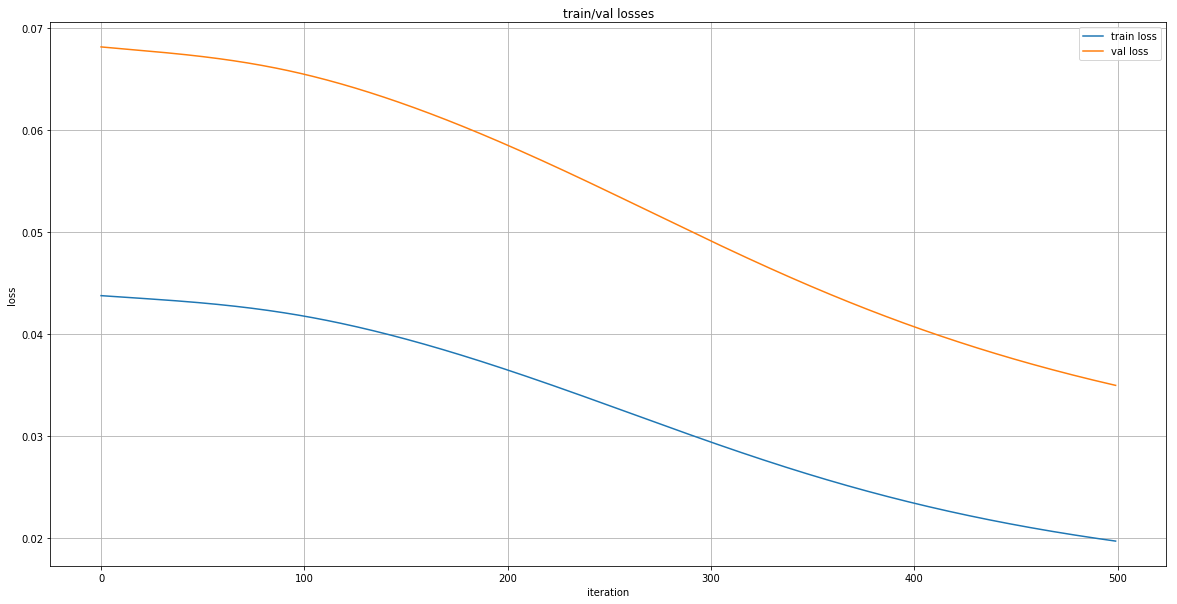

In [9]:
plt.figure(figsize=(20, 10))

for phase in ['train', 'val']:
    plt.plot(losses[phase], label='{} loss'.format(phase))
 
plt.legend()

plt.title('train/val losses')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.grid(True)